<a href="https://colab.research.google.com/github/maksimluzik/collab/blob/master/logprobs_classification_workshop_2025_09_05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## What's in this tutorial?

This tutorial covers how to best do text classification with prompting and LLMs, in particular via the OpenAI API.

The intended audience is software developers, data scientists, and product managers interested in getting the best results out of LLMs via API calls.

## Intro: Classification

We are still figuring out when and how to use generative AI.

One case where it seems to fit well is in extracting structured information. For example, we could:
- Take a job description, and extract required skills, job title, education requirements, experience requirements, benefits offered, etc.
- Take an image and text description from a classified ad and extract the appropriate product category and other attributes (such as brand, condition, size)
- Take images and text describing a real estate listing and extract keywords

It seems structured data extraction is a good fit for LLMs: we can craft performant pipelines that perform individual extraction tasks at a certain level of performance. We can evaluate the predictive performance relatively easily, due to the straightforward connection to an objective ground truth.

This stands in sharp contrast to more complex applications like autonomous AI agents. An agent might involve a long sequence of tasks (e.g., understand a goal, choose a tool, use the tool, analyze the result, repeat). For example, even if each step is 90% reliable, the probability of a sequence of seven steps working correctly has the success rate of a coin flip ($0.9^{7} \approx 48\%$). The sequences of heterogeneous actions performed by agents makes them powerful, but difficult to engineer reliably.

For that reason, focusing on well-defined extraction and classification tasks is one of the best ways to deliver real-world value with LLMs right now.
<center>🐍 🐍 🐍</center>

Frequently, extracting structured information can be framed as a _classification_ problem - that is, choosing from a predefined set of possibilities. For instance:
- Pre-defined set of skills
- Pre-defined set of job titles
- Pre-defined set of keywords, etc.

Pre-ChatGPT, the way to do this was to train a classifier on a dataset of examples, each example including input data and associated _labels_. For example, input text documents and output keywords.

There are established techniques that do a good job of this (for example, tf-idf+svm, and BERT). However, training custom models in this requires:
1) Some technical proficiency in machine learning (ML)
2) Infrastructure to serve the model, which then must be maintained
3) Historical input/example pairs of sufficient quality

In contrast, by running LLMs with API calls (such as OpenAI's models, Gemini, Anthropic, etc.) all of these problems are reduced:
1) ➡️ We don't need to know about ML to do classify input examples - just how to prompt an LLM via an API
2) ➡️ The LLM provider takes care of the model serving infrastructure
3) ➡️ By calling the LLM with a prompt, we don't need to provide any historical examples (this is known as _zero-shot_ classification)

For a data scientist, it may appear somewhat obscene to use a huge LLMs (sometimes hundreds-of-billions of parameters) to perform a task that a much simpler model can tackle. But in practice, the above three factors seem to be prevailing in many use cases.

My own view is that we should lean into this to get the most out of LLMs in this way. There are many more places we might make use of classification beyond cases with historical labelled data; after all, each decision we make in the world could be considered a classification problem.

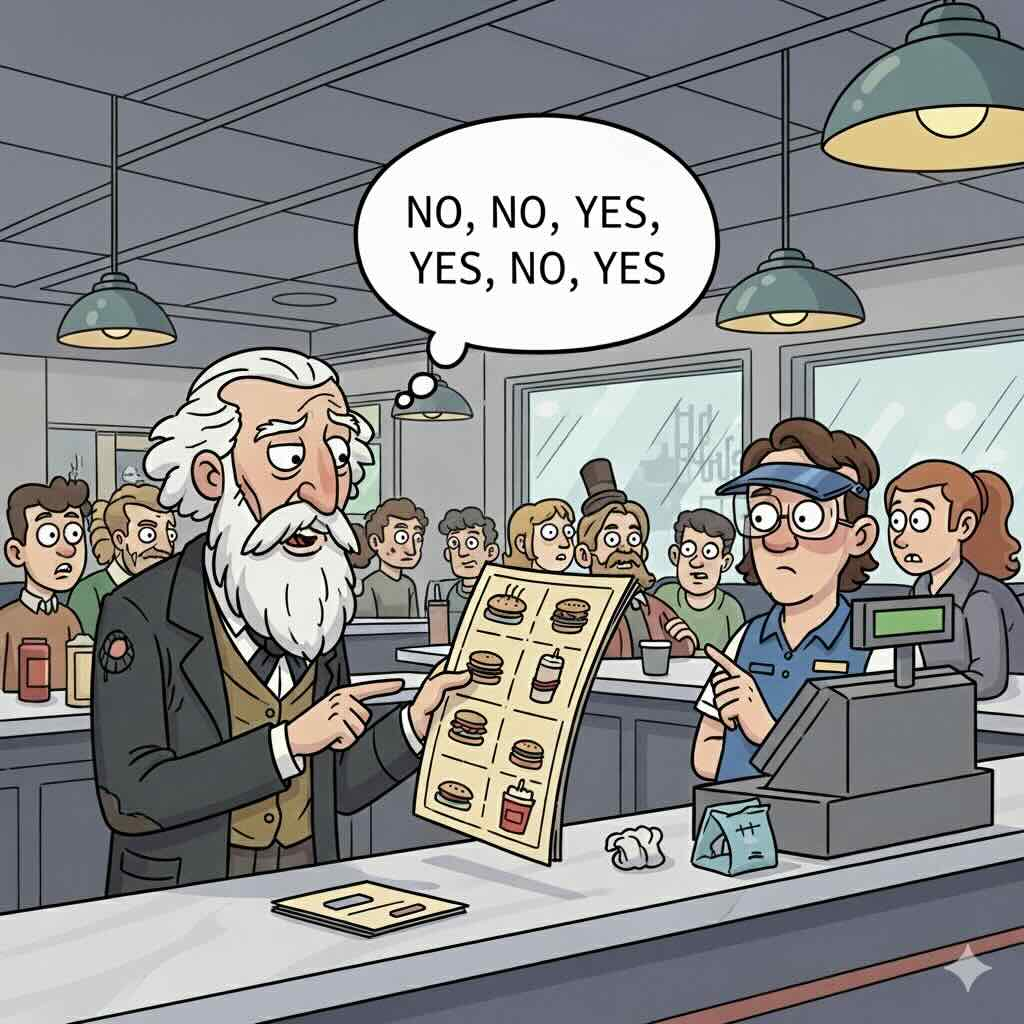

## Setup (just run this + enter your OpenAPI key)

In [ ]:
# Read the API key into an environment variable and also avoid it ending up in the notebook
import os
from getpass import getpass
from openai import OpenAI

api_key = getpass("Enter your OpenAI API key:")
os.environ["OPENAI_API_KEY"] = api_key

Enter your OpenAI API key:··········


In [ ]:
client = OpenAI()

In [ ]:
# Note: Run this command and also click to restart the session
!pip install -U "datasets==3.6.0"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 17.4 MB/s eta 0:00:00
  Attempting uninstall: datasets
    Found existing installation: datasets 4.0.0
    Uninstalling datasets-4.0.0:
      Successfully uninstalled datasets-4.0.0


In [ ]:
import gc
import json
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn.functional as F
import concurrent.futures
from collections import Counter
from itertools import chain
from functools import partial
from tqdm.notebook import tqdm
from datasets import load_dataset
from transformers import AutoModelForCausalLM, AutoTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import make_pipeline
import pandas as pd
from sklearn.metrics import (
    auc,
    classification_report,
    precision_recall_curve,
    average_precision_score,
    roc_auc_score,
    roc_curve,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
)

In [ ]:
pd.set_option("display.max_colwidth", None)

In [ ]:
%%capture
# Load model into cache now so it doesn't slow down the tutorial later on
AutoModelForCausalLM.from_pretrained("Qwen/Qwen2.5-1.5B-Instruct", device_map="auto")

## Intro: Logprobs

### Why logprobs?

There are various ways to do classification with LLMs. This tutorial aims to help you do it _well_, and to therefore achieve better results (in terms of classification performance, cost, and latency).

To do classification well we want to be able to adjust the stringency of our predictions. To easily do that, we need a _score_ associated with each classification call.

This is where logprobs come in.

The idea of using logprobs to do classification has been promoted by leaders in the field (for example, Michelle Pokrass, Andrej Karpathy).

Logprobs allow us to get a _score_ back for each classification call, which can then be used for controlling how permissive or restrictive the predictions are.

### What _are_ logprobs?

- After the last layer of the neural network (LLM, so transformer architecture), a softmax funciton is applied to get probabilities that sum to 1.
- Logprobs are just the mathematical log of these probabilities
- It's better to work with log values since probabilities can be close to zero (floating point math precision, addition faster than multiplication)
![2-logits.png](https://huyenchip.com/assets/pics/sampling/4-logprobs.png)
(From https://huyenchip.com/2024/01/16/sampling.html?utm_source=chatgpt.com)

### Get logprobs with an OpenAI model

In [ ]:
# Example of getting logprobs back from an OpenAI API call
user_prompt = "I'm testing something out. Please just say the sentence \"This is an apple.\"."
completion = client.chat.completions.create(
  model="gpt-4o-mini",
  messages=[
    {"role": "developer", "content": "You are a helpful assistant"},
    {"role": "user", "content": user_prompt},
  ],
  logprobs=True,
  top_logprobs=20,
)

In [ ]:
completion_dict = completion.model_dump()

In [ ]:
completion_dict["choices"][0]["message"]["content"]

'This is an apple.'

In [ ]:
completion_dict

{'id': 'chatcmpl-CDrkhv1ywM4j14wR5952MOSfA0EDA',
 'choices': [{'finish_reason': 'stop',
   'index': 0,
   'logprobs': {'content': [{'token': 'This',
      'bytes': [84, 104, 105, 115],
      'logprob': -1.0280383548888494e-06,
      'top_logprobs': [{'token': 'This',
        'bytes': [84, 104, 105, 115],
        'logprob': -1.0280383548888494e-06},
       {'token': 'Sure',
        'bytes': [83, 117, 114, 101],
        'logprob': -14.250000953674316},
       {'token': '"This',
        'bytes': [34, 84, 104, 105, 115],
        'logprob': -15.125000953674316},
       {'token': ' This',
        'bytes': [32, 84, 104, 105, 115],
        'logprob': -17.500001907348633},
       {'token': 'Certainly',
        'bytes': [67, 101, 114, 116, 97, 105, 110, 108, 121],
        'logprob': -20.000001907348633},
       {'token': '“This',
        'bytes': [226, 128, 156, 84, 104, 105, 115],
        'logprob': -20.875001907348633},
       {'token': '_this',
        'bytes': [95, 116, 104, 105, 115],
     

In [ ]:
output_tok_logprobs = completion_dict["choices"][0]["logprobs"]["content"]

In [ ]:
output_tok_logprobs[0]["top_logprobs"]

[{'token': 'This',
  'bytes': [84, 104, 105, 115],
  'logprob': -1.0280383548888494e-06},
 {'token': 'Sure',
  'bytes': [83, 117, 114, 101],
  'logprob': -14.250000953674316},
 {'token': '"This',
  'bytes': [34, 84, 104, 105, 115],
  'logprob': -15.125000953674316},
 {'token': ' This',
  'bytes': [32, 84, 104, 105, 115],
  'logprob': -17.500001907348633},
 {'token': 'Certainly',
  'bytes': [67, 101, 114, 116, 97, 105, 110, 108, 121],
  'logprob': -20.000001907348633},
 {'token': '“This',
  'bytes': [226, 128, 156, 84, 104, 105, 115],
  'logprob': -20.875001907348633},
 {'token': '_this',
  'bytes': [95, 116, 104, 105, 115],
  'logprob': -21.625001907348633},
 {'token': 'this',
  'bytes': [116, 104, 105, 115],
  'logprob': -21.750001907348633},
 {'token': 'The', 'bytes': [84, 104, 101], 'logprob': -21.750001907348633},
 {'token': 'Here',
  'bytes': [72, 101, 114, 101],
  'logprob': -21.750001907348633},
 {'token': '>This',
  'bytes': [62, 84, 104, 105, 115],
  'logprob': -22.50000190734

In [ ]:
output_tok_logprobs[1]["top_logprobs"]

[{'token': ' is', 'bytes': [32, 105, 115], 'logprob': 0.0},
 {'token': 'is', 'bytes': [105, 115], 'logprob': -22.5625},
 {'token': '\tis', 'bytes': [9, 105, 115], 'logprob': -22.625},
 {'token': ' هو', 'bytes': [32, 217, 135, 217, 136], 'logprob': -23.25},
 {'token': '是', 'bytes': [230, 152, 175], 'logprob': -23.9375},
 {'token': ' Is', 'bytes': [32, 73, 115], 'logprob': -24.25},
 {'token': ' an', 'bytes': [32, 97, 110], 'logprob': -24.875},
 {'token': ' ', 'bytes': [32], 'logprob': -25.375},
 {'token': ' a', 'bytes': [32, 97], 'logprob': -25.4375},
 {'token': '.is', 'bytes': [46, 105, 115], 'logprob': -25.5625},
 {'token': ' IS', 'bytes': [32, 73, 83], 'logprob': -25.6875},
 {'token': ' sentence',
  'bytes': [32, 115, 101, 110, 116, 101, 110, 99, 101],
  'logprob': -25.875},
 {'token': '_is', 'bytes': [95, 105, 115], 'logprob': -26.1875},
 {'token': ' apple',
  'bytes': [32, 97, 112, 112, 108, 101],
  'logprob': -26.375},
 {'token': ' é', 'bytes': [32, 195, 169], 'logprob': -26.5625},

In [ ]:
output_tok_logprobs[2]["top_logprobs"]

[{'token': ' a', 'bytes': [32, 97], 'logprob': 0.0},
 {'token': ' а', 'bytes': [32, 208, 176], 'logprob': -23.125},
 {'token': ' the', 'bytes': [32, 116, 104, 101], 'logprob': -23.875},
 {'token': ' just', 'bytes': [32, 106, 117, 115, 116], 'logprob': -26.0},
 {'token': ' ', 'bytes': [32], 'logprob': -26.0625},
 {'token': '\ta', 'bytes': [9, 97], 'logprob': -26.75},
 {'token': 'a', 'bytes': [97], 'logprob': -27.125},
 {'token': ' A', 'bytes': [32, 65], 'logprob': -27.3125},
 {'token': ' aa', 'bytes': [32, 97, 97], 'logprob': -27.625},
 {'token': '\xa0', 'bytes': [194, 160], 'logprob': -27.75},
 {'token': ' indeed',
  'bytes': [32, 105, 110, 100, 101, 101, 100],
  'logprob': -28.1875},
 {'token': ' an', 'bytes': [32, 97, 110], 'logprob': -28.25},
 {'token': '\n\n', 'bytes': [10, 10], 'logprob': -28.4375},
 {'token': ' not', 'bytes': [32, 110, 111, 116], 'logprob': -28.5625},
 {'token': ' your', 'bytes': [32, 121, 111, 117, 114], 'logprob': -28.6875},
 {'token': ' test', 'bytes': [32, 11

In [ ]:
output_tok_logprobs[3]["top_logprobs"]

[{'token': ' test', 'bytes': [32, 116, 101, 115, 116], 'logprob': 0.0},
 {'token': ' тест',
  'bytes': [32, 209, 130, 208, 181, 209, 129, 209, 130],
  'logprob': -23.125},
 {'token': ' Test', 'bytes': [32, 84, 101, 115, 116], 'logprob': -24.25},
 {'token': 'test', 'bytes': [116, 101, 115, 116], 'logprob': -24.875},
 {'token': '\ttest', 'bytes': [9, 116, 101, 115, 116], 'logprob': -25.375},
 {'token': ' text', 'bytes': [32, 116, 101, 120, 116], 'logprob': -25.625},
 {'token': '.test', 'bytes': [46, 116, 101, 115, 116], 'logprob': -26.0},
 {'token': '_test', 'bytes': [95, 116, 101, 115, 116], 'logprob': -26.375},
 {'token': ' tes', 'bytes': [32, 116, 101, 115], 'logprob': -26.375},
 {'token': 'Test', 'bytes': [84, 101, 115, 116], 'logprob': -26.875},
 {'token': ' testament',
  'bytes': [32, 116, 101, 115, 116, 97, 109, 101, 110, 116],
  'logprob': -27.0},
 {'token': '(test', 'bytes': [40, 116, 101, 115, 116], 'logprob': -27.5},
 {'token': '-test', 'bytes': [45, 116, 101, 115, 116], 'logp

In [ ]:
output_tok_logprobs[4]["top_logprobs"]

[{'token': '.', 'bytes': [46], 'logprob': -1.0280383548888494e-06},
 {'token': '.\n', 'bytes': [46, 10], 'logprob': -14.125000953674316},
 {'token': '.\n\n', 'bytes': [46, 10, 10], 'logprob': -16.375001907348633},
 {'token': '..', 'bytes': [46, 46], 'logprob': -17.000001907348633},
 {'token': '."', 'bytes': [46, 34], 'logprob': -17.375001907348633},
 {'token': '.user',
  'bytes': [46, 117, 115, 101, 114],
  'logprob': -18.625001907348633},
 {'token': '.:', 'bytes': [46, 58], 'logprob': -18.750001907348633},
 {'token': '.s', 'bytes': [46, 115], 'logprob': -19.125001907348633},
 {'token': '._', 'bytes': [46, 95], 'logprob': -19.125001907348633},
 {'token': '.r', 'bytes': [46, 114], 'logprob': -19.250001907348633},
 {'token': '.”', 'bytes': [46, 226, 128, 157], 'logprob': -19.375001907348633},
 {'token': '.@', 'bytes': [46, 64], 'logprob': -19.625001907348633},
 {'token': '.<', 'bytes': [46, 60], 'logprob': -19.750001907348633},
 {'token': '.]', 'bytes': [46, 93], 'logprob': -19.750001907

### What about temperature when getting logprobs?

In [ ]:
logits = torch.tensor([2.0, 1.0, 0.1])

# 2. Define a few different temperature values to test
temperatures = [0.1, 0.5, 1.0, 5.0, 10.0]

print(f"Original Logits: {logits}\n" + "="*40)

# 3. Loop through each temperature and apply the softmax function
for T in temperatures:
    print(f"Temperature (T) = {T}:")

    # The core of the temperature scaling: divide logits by the temperature
    scaled_logits = logits / T

    # Apply the softmax function to the scaled logits
    # The result is a probability distribution
    probabilities = F.softmax(scaled_logits, dim=0)

    print(f"  -> Scaled Logits: {scaled_logits.numpy().round(2)}")
    print(f"  -> Probabilities: {probabilities.numpy().round(4)}")
    print("-"*40)

Original Logits: tensor([2.0000, 1.0000, 0.1000])
Temperature (T) = 0.1:
  -> Scaled Logits: [20. 10.  1.]
  -> Probabilities: [1. 0. 0.]
----------------------------------------
Temperature (T) = 0.5:
  -> Scaled Logits: [4.  2.  0.2]
  -> Probabilities: [0.8638 0.1169 0.0193]
----------------------------------------
Temperature (T) = 1.0:
  -> Scaled Logits: [2.  1.  0.1]
  -> Probabilities: [0.659  0.2424 0.0986]
----------------------------------------
Temperature (T) = 5.0:
  -> Scaled Logits: [0.4  0.2  0.02]
  -> Probabilities: [0.3996 0.3272 0.2733]
----------------------------------------
Temperature (T) = 10.0:
  -> Scaled Logits: [0.2  0.1  0.01]
  -> Probabilities: [0.3661 0.3312 0.3027]
----------------------------------------


### Let's check the impact of temperature on logprobs (with an open-weights model)

In [ ]:
model_id = "Qwen/Qwen2.5-1.5B-Instruct"
tok = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(model_id, device_map="auto")

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

In [ ]:
outputs = model.generate(
    **tok("What is the capital city of Australia? One-word response please.", return_tensors="pt").to(model.device),
    max_new_tokens=1,
    return_dict_in_generate=True,
    output_scores=True,
    do_sample=True,
    top_k=0,
    top_p=1.0,
    typical_p=1.0,
    temperature=1.0,
    #temperature=0.1,
    #temperature=10.0,
)

logits = outputs.scores[0]  # shape: [batch_size, vocab_size]
logprobs = F.log_softmax(logits, dim=-1)
topk = torch.topk(logprobs[0], k=20)
for log_prob, token_id in zip(topk.values, topk.indices):
    prob = log_prob.exp().item()
    print(f"Token: {tok.decode(token_id)}\tLogprob: {log_prob:0.2g}\tProbability: {prob:.2g}")

Token:  Canberra	Logprob: -0.15	Probability: 0.86
Token:  Sydney	Logprob: -3	Probability: 0.051
Token:  The	Logprob: -4.1	Probability: 0.016
Token:  Melbourne	Logprob: -4.4	Probability: 0.013
Token:  

	Logprob: -4.5	Probability: 0.011
Token:  Can	Logprob: -4.8	Probability: 0.008
Token:  
	Logprob: -5	Probability: 0.0066
Token:  What	Logprob: -5.1	Probability: 0.0061
Token:  **	Logprob: -5.6	Probability: 0.0038
Token:  Brisbane	Logprob: -5.9	Probability: 0.0027
Token:  	Logprob: -6.2	Probability: 0.002
Token:  (	Logprob: -6.3	Probability: 0.0019
Token:   
	Logprob: -6.4	Probability: 0.0016
Token:  To	Logprob: -6.9	Probability: 0.0011
Token:  Capital	Logprob: -7	Probability: 0.00094
Token:  Australia	Logprob: -7	Probability: 0.00092
Token:  Answer	Logprob: -7	Probability: 0.00091
Token:  *	Logprob: -7.3	Probability: 0.00068
Token:  Please	Logprob: -7.4	Probability: 0.00059
Token:  __	Logprob: -7.5	Probability: 0.00056


## Binary classification

By phrasing the prompt as just "yes or no" and asking for a single token back, we can do binary classification

In [ ]:
system_prompt = 'You are the French philosopher, Voltaire.'
#user_prompt = 'Was the Holy Roman Empire "Holy"? Yes or No.'
#user_prompt = 'Was the Holy Roman Empire "Roman"? Yes or No.'
user_prompt = 'Was the Holy Roman Empire an "Empire"? Yes or No.'

completion = client.chat.completions.create(
  model="gpt-4o-mini",
  messages=[
    {"role": "developer", "content": system_prompt},
    {"role": "user", "content": user_prompt},
  ],
  max_tokens=1,
  logprobs=True,
  top_logprobs=20,
)

top_logprobs_first_token = completion.choices[0].logprobs.content[0].top_logprobs
token_to_logprob = {item.token:item.logprob for item in top_logprobs_first_token}

We can see that "Yes" and "No" are amongst the 20 most-probable tokens, amongst others

In [ ]:
token_to_logprob

{'The': -0.1873285323381424,
 'Yes': -2.187328577041626,
 'In': -3.437328577041626,
 'No': -4.312328338623047,
 'To': -5.812328338623047,
 'Ah': -5.937328338623047,
 'As': -6.312328338623047,
 'It': -6.437328338623047,
 'While': -6.437328338623047,
 'Whether': -7.187328338623047,
 'If': -7.687328338623047,
 'This': -8.187328338623047,
 'Indeed': -8.687328338623047,
 'One': -8.812328338623047,
 'That': -9.062328338623047,
 'Oui': -9.187328338623047,
 'From': -9.687328338623047,
 'Techn': -10.312328338623047,
 'Though': -10.312328338623047,
 'Although': -10.437328338623047}

To get a score, we take the yes score minus the no score. A score > 0 means the model thinks yes is more probable no.

In [ ]:
yes_score = -20 if "Yes" not in token_to_logprob else token_to_logprob["Yes"]
no_score = -20 if "No" not in token_to_logprob else token_to_logprob["No"]

print(yes_score - no_score)

2.124999761581421


## Multi-label classification

There are at least two problems with the above approach:
- What if "Yes" and "No" don't occur in the top-20 output tokens?
- Expensive if we want to make many binary predictions at the same time

Predicting multiple separate binary variables at the same time is known as "multi-label classification".

 Let's see how we might do that better, using ✨ _structured outputs_ ✨

In [ ]:
# We specify a json schema in our API call.
# Each binary attribute is specified as a boolean-typed property, along with a description:
response_format = {
    "type": "json_schema",
    "json_schema": {
        "name": "multilabel_classification",
        "strict": True,
        "schema": {
            "type": "object",
            "properties": {
                "IsHoly": {
                    "type": "boolean",
                    "description": "Whether something can be considered holy or not",
                },
                "IsRoman": {
                    "type": "boolean",
                    "description": "Whether something can be considered Roman or not",
                },
                "IsAnEmpire": {
                    "type": "boolean",
                    "description": "Whether something can be considered an empire or not",
                },
            },
            "required": ["IsHoly", "IsRoman", "IsAnEmpire"],
            "additionalProperties": False,
        },
    },
}

completion = client.chat.completions.create(
    model="gpt-4o",
    messages=[
        #{"role": "system", "content": "You are a helpful assistant."},
        {"role": "system", "content": "You are the French philosopher, Voltaire."},
        {"role": "user", "content": "Specify attributes relating to the Holy Roman Empire"},
    ],
    response_format=response_format,
    logprobs=True,
    top_logprobs=20,
)

As we'd specified, the output includes our three binary attributes (with boolean values):

In [ ]:
completion.choices[0].message.content

'{"IsHoly":false,"IsRoman":false,"IsAnEmpire":false}'

There's a technical challenge: We want to extract the logprobs for true and false _at specific token positions_.

Doing this properly would require parsing the json string alongside the logprob data. In python, this is not supported by widely-used libraries such as json and ijson, and implementing parsing ourselves would require some work.

Here, let's use a simpler (albeit hacky) solution that will do the job...

First, we find the positions where boolean-valued tokens occur:

In [ ]:
logprob_content = completion.choices[0].logprobs.content
key_tokens_of_interest = ["true", "false"]
boolean_token_positions = [
  idx for idx, curr_token_logrobs in enumerate(logprob_content)
  if curr_token_logrobs.token in key_tokens_of_interest
]

We can see that the boolean outputs seem to adhere well to just true or false:

In [ ]:
logprob_content[boolean_token_positions[0]].top_logprobs

[TopLogprob(token='false', bytes=[102, 97, 108, 115, 101], logprob=-0.004622018430382013),
 TopLogprob(token='true', bytes=[116, 114, 117, 101], logprob=-5.379621982574463),
 TopLogprob(token=' false', bytes=[32, 102, 97, 108, 115, 101], logprob=-13.254622459411621),
 TopLogprob(token='\tfalse', bytes=[9, 102, 97, 108, 115, 101], logprob=-17.879621505737305),
 TopLogprob(token=' true', bytes=[32, 116, 114, 117, 101], logprob=-18.129621505737305),
 TopLogprob(token='fa', bytes=[102, 97], logprob=-19.629621505737305),
 TopLogprob(token='f', bytes=[102], logprob=-20.192121505737305),
 TopLogprob(token='fal', bytes=[102, 97, 108], logprob=-20.254621505737305),
 TopLogprob(token='\ttrue', bytes=[9, 116, 114, 117, 101], logprob=-22.567121505737305),
 TopLogprob(token='tr', bytes=[116, 114], logprob=-22.817121505737305),
 TopLogprob(token='tru', bytes=[116, 114, 117], logprob=-23.567121505737305),
 TopLogprob(token=' ', bytes=[32], logprob=-24.254621505737305),
 TopLogprob(token='t', bytes=[1

Now the hack part: We look to the immediate left of each boolean-valued token, and match that text against the designated attribute names:

In [ ]:
attribute_to_score = {}
attributes = ["IsHoly", "IsRoman", "IsAnEmpire"]
block_start_token_idx = 0
for curr_boolean_token_idx in boolean_token_positions:
  preceding_text = "".join([
    curr_token_info.token for curr_token_info in
    logprob_content[block_start_token_idx:curr_boolean_token_idx]
  ])
  curr_token_probs = {
    possible_token.token: possible_token.logprob
    for possible_token in logprob_content[curr_boolean_token_idx].top_logprobs
  }
  classification_score = curr_token_probs["true"] - curr_token_probs["false"]
  print(f"Preceding text: {preceding_text}")
  for attribute in attributes:
    if '"' + attribute + '"' in preceding_text:
      print(f"Attribute: {attribute} -> score {classification_score}")
      attribute_to_score[attribute] = classification_score

  block_start_token_idx = curr_boolean_token_idx + 1

Preceding text: {"IsHoly":
Attribute: IsHoly -> score -5.374999964144081
Preceding text: ,"IsRoman":
Attribute: IsRoman -> score -4.499999930150807
Preceding text: ,"IsAnEmpire":
Attribute: IsAnEmpire -> score -1.4999999850988388


So now we have scores for each of our binary variables of interest!

In [ ]:
attribute_to_score

{'IsHoly': -5.374999964144081,
 'IsRoman': -4.499999930150807,
 'IsAnEmpire': -1.4999999850988388}

Let's go ahead and make a generic multi-label classification function that works with any attribute and associated attribute values:

In [ ]:
def classify_text_multilabel(system_prompt, text_to_classify, attribute_value_to_description, model="gpt-4o"):
    properties_dict = {
        attribute_value: {
            "type": "boolean",
            "description": attribute_value_description,
        }
        for attribute_value, attribute_value_description in attribute_value_to_description.items()
    }

    response_format = {
        "type": "json_schema",
        "json_schema": {
            "name": "multilabel_classification",
            "strict": True,
            "schema": {
                "type": "object",
                "properties": properties_dict,
                "required": list(attribute_value_to_description.keys()),
                "additionalProperties": False,
            },
        },
    }

    completion = client.chat.completions.create(
        model=model,
        messages=[
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": text_to_classify},
        ],
        response_format=response_format,
        logprobs=True,
        top_logprobs=20,
    )

    logprob_content = completion.choices[0].logprobs.content
    key_tokens_of_interest = ["true", "false"]
    boolean_token_positions = [
        idx for idx, curr_token_logrobs in enumerate(logprob_content)
        if curr_token_logrobs.token in key_tokens_of_interest
    ]

    attribute_to_score = {}
    block_start_token_idx = 0
    for curr_boolean_token_idx in boolean_token_positions:
        preceding_text = "".join([
            curr_token_info.token for curr_token_info in
            logprob_content[block_start_token_idx:curr_boolean_token_idx]
        ])
        curr_token_probs = {
            possible_token.token: possible_token.logprob
            for possible_token in logprob_content[curr_boolean_token_idx].top_logprobs
        }
        classification_score = curr_token_probs["true"] - curr_token_probs["false"]
        for attribute in attribute_value_to_description.keys():
            if '"' + attribute + '"' in preceding_text:
                attribute_to_score[attribute] = classification_score

        block_start_token_idx = curr_boolean_token_idx + 1

    return attribute_to_score

In [ ]:
classify_text_multilabel(
    "You are the French philosopher, Voltaire. You will receive an entity. Give your honest and unvarnished opinion on it.",
    "The Holy Roman Empire",
    #"A piece of cheesecake.",
    #"A piece of cheesecake, excavated from Pompeii.",
    {
        "IsHoly": "Whether something can be considered holy or not",
        "IsRoman": "Whether something can be considered Roman or not",
        "IsAnEmpire": "Whether something can be considered an empire or not",
    }
)

{'IsHoly': -9.500000167550752,
 'IsRoman': -3.375000037252903,
 'IsAnEmpire': 2.624999925494194}

In [ ]:
classify_text_multilabel(
    "You are an expert in recommerce. You will receive the title and text description from a recommerce listing. Your task is to determine which categories match that product listing.",
    "Title: Nike Air Max bolt CW1626-003\nDescription: Brukt 2 ganger. Som nye. Selges hbo kr 350 pluss porto",
    {
        "Ballerinasko": "True if the product belongs to the category \"Ballerinasko\", false otherwise.",
        "Hæler": "True if the product belongs to the category \"Hæler\", false otherwise.",
        "Mokkasiner og båtsko": "True if the product belongs to the category \"Mokkasiner og båtsko\", false otherwise.",
        "Pensko": "True if the product belongs to the category \"Pensko\", false otherwise.",
        "Regnstøvler": "True if the product belongs to the category \"Regnstøvler\", false otherwise.",
        "Sandaler": "True if the product belongs to the category \"Sandaler\", false otherwise.",
        "Slippers": "True if the product belongs to the category \"Slippers\", false otherwise.",
        "Sneakers/joggesko": "True if the product belongs to the category \"Sneakers/joggesko\", false otherwise.",
        "Støvler": "True if the product belongs to the category \"Støvler\", false otherwise.",
        "Tøfler og tresko": "True if the product belongs to the category \"Tøfler og tresko\", false otherwise.",
        "Vinterstøvler": "True if the product belongs to the category \"Vinterstøvler\", false otherwise.",
        "Andre sko": "True if the product belongs to the category \"Andre sko\", false otherwise.",
    }
)

{'Ballerinasko': -29.25,
 'Hæler': -25.375,
 'Mokkasiner og båtsko': -21.625,
 'Pensko': -14.625000402450667,
 'Regnstøvler': -21.25,
 'Sandaler': -20.75,
 'Slippers': -15.249999687183674,
 'Sneakers/joggesko': 17.25,
 'Støvler': -15.124999687183674,
 'Tøfler og tresko': -19.5,
 'Vinterstøvler': -18.625,
 'Andre sko': -7.37499978824053}

## Classification on a labelled dataset

Let's apply our LLM-base multi-label classification on the [GoEmotions](https://huggingface.co/papers/2005.00547) dataset, which includes Reddit posts and associated fine-grained emotions.

In [ ]:
ds = load_dataset("google-research-datasets/go_emotions", "simplified")

README.md: 0.00B [00:00, ?B/s]

simplified/train-00000-of-00001.parquet:   0%|          | 0.00/2.77M [00:00<?, ?B/s]

simplified/validation-00000-of-00001.par(…):   0%|          | 0.00/350k [00:00<?, ?B/s]

simplified/test-00000-of-00001.parquet:   0%|          | 0.00/347k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/43410 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/5426 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5427 [00:00<?, ? examples/s]

There are 27 possible emotions in the dataset, plus neutral

In [ ]:
label_names = ds["train"].features["labels"].feature.names

In [ ]:
len(label_names)

28

In [ ]:
label_names

['admiration',
 'amusement',
 'anger',
 'annoyance',
 'approval',
 'caring',
 'confusion',
 'curiosity',
 'desire',
 'disappointment',
 'disapproval',
 'disgust',
 'embarrassment',
 'excitement',
 'fear',
 'gratitude',
 'grief',
 'joy',
 'love',
 'nervousness',
 'optimism',
 'pride',
 'realization',
 'relief',
 'remorse',
 'sadness',
 'surprise',
 'neutral']

Prepare the train and validation data for our purposes

In [ ]:
train_labels = [
    [label_names[label_idx] for label_idx in label_idxs]
    for label_idxs in ds["train"]["labels"]
]

val_labels = [
    [label_names[label_idx] for label_idx in label_idxs]
    for label_idxs in ds["validation"]["labels"]
]

An example item - text and list of associated emotions. I chose a nice one so your eyes don't bleed 😀

In [ ]:
example_text = ds["train"]["text"][13]
example_labels = train_labels[13]
print(example_text)
print(example_labels)

R/sleeptrain Might be time for some sleep training. Take a look and try to feel out what's right for your family.
['caring']


Let's run multi-label prediction with an example:

In [ ]:
# (Required for our multi-label classification function)
label_to_description = {
    label: f"True if the text expresses the emotion \"{label}\", otherwise false."
    for label in label_names
}

In [ ]:
label_to_description

{'admiration': 'True if the text expresses the emotion "admiration", otherwise false.',
 'amusement': 'True if the text expresses the emotion "amusement", otherwise false.',
 'anger': 'True if the text expresses the emotion "anger", otherwise false.',
 'annoyance': 'True if the text expresses the emotion "annoyance", otherwise false.',
 'approval': 'True if the text expresses the emotion "approval", otherwise false.',
 'caring': 'True if the text expresses the emotion "caring", otherwise false.',
 'confusion': 'True if the text expresses the emotion "confusion", otherwise false.',
 'curiosity': 'True if the text expresses the emotion "curiosity", otherwise false.',
 'desire': 'True if the text expresses the emotion "desire", otherwise false.',
 'disappointment': 'True if the text expresses the emotion "disappointment", otherwise false.',
 'disapproval': 'True if the text expresses the emotion "disapproval", otherwise false.',
 'disgust': 'True if the text expresses the emotion "disgust

In [ ]:
result = classify_text_multilabel(
    "You are a helpful assistant. You will receive a Reddit comment text. Your task is to evaluate which emotions are expressed in that comment.",
    example_text,
    label_to_description,
)
pd.Series(result).sort_values(ascending=False)

,0
approval,0.750
caring,0.625
neutral,0.500
optimism,-1.125
realization,-4.000
desire,-4.250
love,-5.500
curiosity,-6.250
relief,-9.625
disapproval,-10.500


## Precision-recall analysis

Using the above approach, let's make predictions for some items, and do a [precision-recall](https://en.wikipedia.org/wiki/Precision_and_recall) analysis for each of the most common categories.

(Background): For a given binary variable (in this case, whether or not a given emotion is expressed in the text), _precision_ measures the fraction of our positive calls that are correct, and _recall_ measures the fraction of all positive occurrences that we manage to successfully call. We can trade off one for the other by varying our score threshold when making our positive calls.

In [ ]:
train_df = pd.DataFrame({"text": ds["train"]["text"], "labels": train_labels})

We'll measure performance on a small sub-set of the validation dataset (to avoid spending too much on API calls)

In [ ]:
val_df = pd.DataFrame({"text": ds["validation"]["text"], "labels": val_labels})
sample_df = val_df.sample(300, random_state=42)

Let's consider every emotion with at least 15 examples, in that sample

In [ ]:
labels_in_sample = list(chain.from_iterable(sample_df.labels))

emotion_counts = Counter(labels_in_sample).most_common()
common_emotions = set([emotion for emotion, count in emotion_counts if count >= 15])
print(common_emotions)

{'neutral', 'gratitude', 'annoyance', 'admiration', 'approval', 'optimism', 'disapproval'}


Now let's generate predictions and evaluate performance using our LLM-based approach

In [ ]:
labels_matrix = np.array(sample_df.labels.apply(lambda l: [label in l for label in common_emotions]).tolist())
labels_df = pd.DataFrame(labels_matrix, columns=list(common_emotions))
labels_df

,neutral,gratitude,annoyance,admiration,approval,optimism,disapproval
0,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False
2,True,False,False,False,False,False,False
3,True,False,False,False,False,False,False
4,True,False,False,False,False,False,False
...,...,...,...,...,...,...,...
295,False,False,False,False,False,False,False
296,True,False,False,False,False,False,False
297,False,False,False,False,False,False,False
298,False,False,False,False,False,False,True


In [ ]:
classify_partial = partial(
    classify_text_multilabel,
    "You are a helpful assistant. You will receive a Reddit comment text. Your task is to evaluate which emotions are expressed in that comment.",
    attribute_value_to_description=label_to_description,
    model="gpt-4o",
)

with concurrent.futures.ProcessPoolExecutor(max_workers=20) as executor:
    results = list(tqdm(executor.map(classify_partial, sample_df.text), total=len(sample_df)))

  0%|          | 0/300 [00:00<?, ?it/s]

In [ ]:
scores_df = pd.DataFrame(results)
scores_df = scores_df.loc[:, list(common_emotions)]
scores_df

,neutral,gratitude,annoyance,admiration,approval,optimism,disapproval
0,-2.875,-4.375,-9.250,-16.750,-3.375,-9.625,-12.500
1,-2.375,-19.500,-3.625,-21.750,-13.000,-11.875,-5.625
2,-5.625,-16.750,-1.750,-27.875,-13.000,-12.750,1.875
3,-2.750,-10.875,-17.500,-10.750,-1.375,5.250,-14.125
4,-6.750,-17.000,-7.000,-28.500,-15.125,-14.875,-9.875
...,...,...,...,...,...,...,...
295,-10.000,-15.000,-12.750,-6.750,1.000,-2.875,-17.250
296,-3.625,-17.625,-2.500,-27.250,-6.875,-11.500,-0.875
297,-3.500,-16.625,-2.125,-20.000,-6.500,-9.000,-3.125
298,-8.500,-18.625,1.875,-25.250,-14.250,-12.375,1.750


In [ ]:
def plot_roc(scores, labels, name):
    fpr, tpr, thresholds = roc_curve(labels, scores)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC: {name}')
    plt.legend(loc="lower right")
    plt.show()

We can see that our predictions are better than random for each of the common emotions

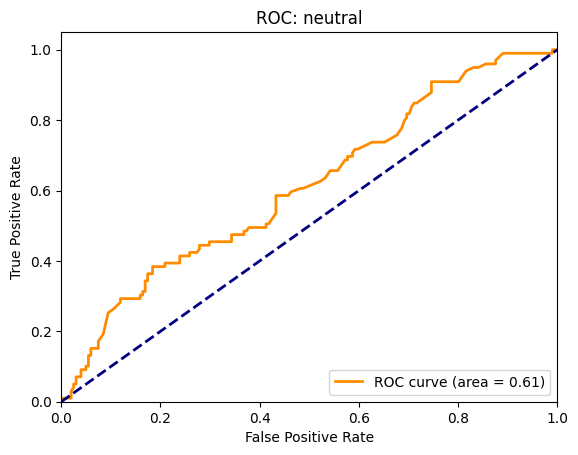

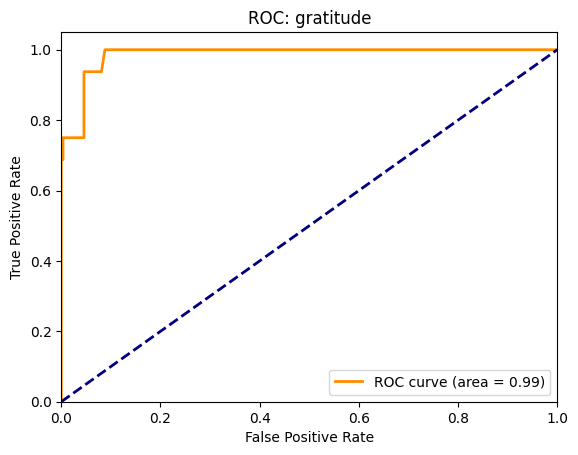

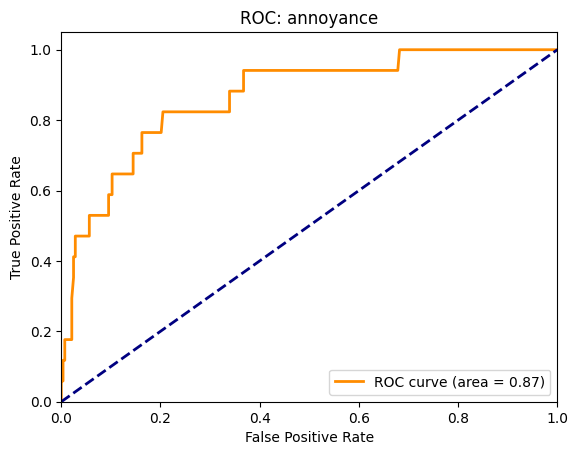

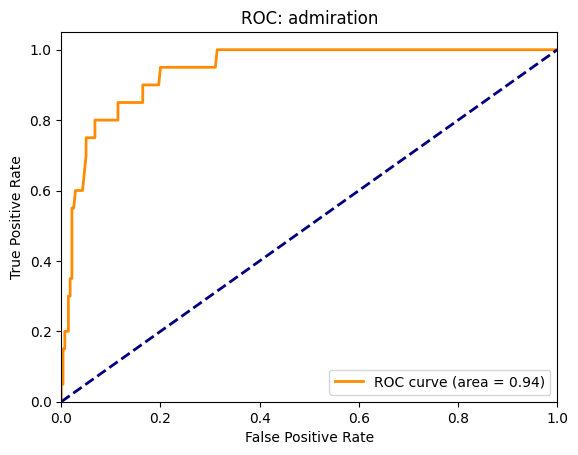

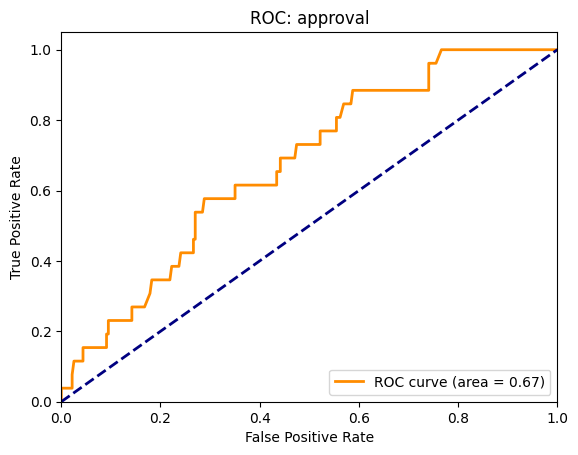

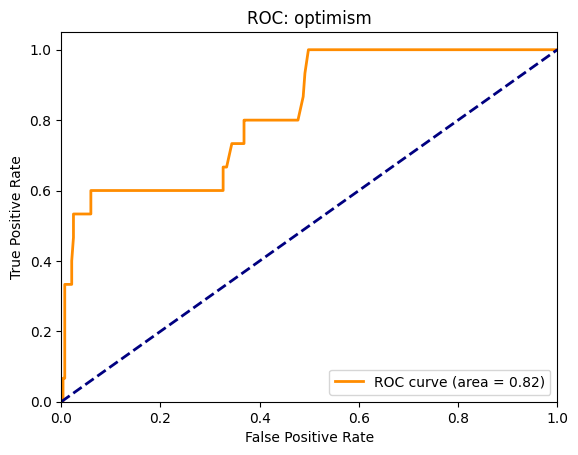

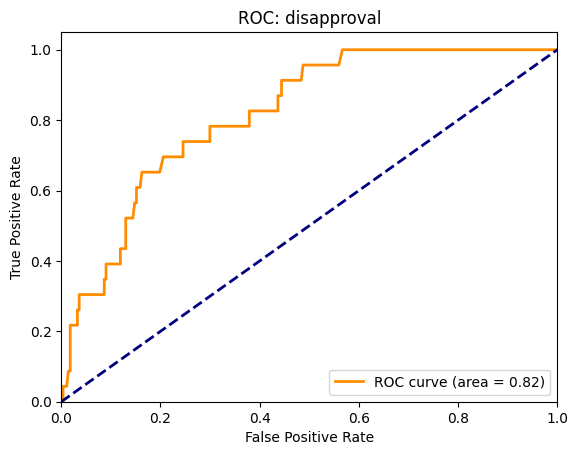

In [ ]:
for emotion in common_emotions:
  plot_roc(scores_df.loc[:, emotion], labels_df.loc[:, emotion], emotion)

Let's visualise the tradeoff between precision and recall for the common emotions

In [ ]:
def compute_metrics_df(scores, labels):
  thresholds = np.linspace(min(scores), max(scores), 200)
  metrics = []
  y_true = labels
  for t in thresholds:
    y_pred = (scores >= t).astype(int)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    metrics.append((t, prec, rec, f1))
  metrics_df = pd.DataFrame(metrics, columns=["threshold", "precision", "recall", "f1"])

  return metrics_df

In [ ]:
def plot_precision_recall(metrics_df, emotion, optimal_threshold):
    plt.figure(figsize=(10, 6))
    plt.plot(metrics_df["threshold"], metrics_df["precision"], label="Precision")
    plt.plot(metrics_df["threshold"], metrics_df["recall"], label="Recall")
    plt.plot(metrics_df["threshold"], metrics_df["f1"], label="F1 Score")
    plt.axvline(optimal_threshold, color='red', linestyle='--', label=f"Optimal Threshold: {optimal_threshold:.4f}")
    plt.xlabel("Logprob Threshold")
    plt.ylabel("Metric Value")
    plt.title(f"Classification Metrics vs Threshold for \"{emotion}\" binary classifier")
    plt.legend()
    plt.grid(True)
    plt.show()

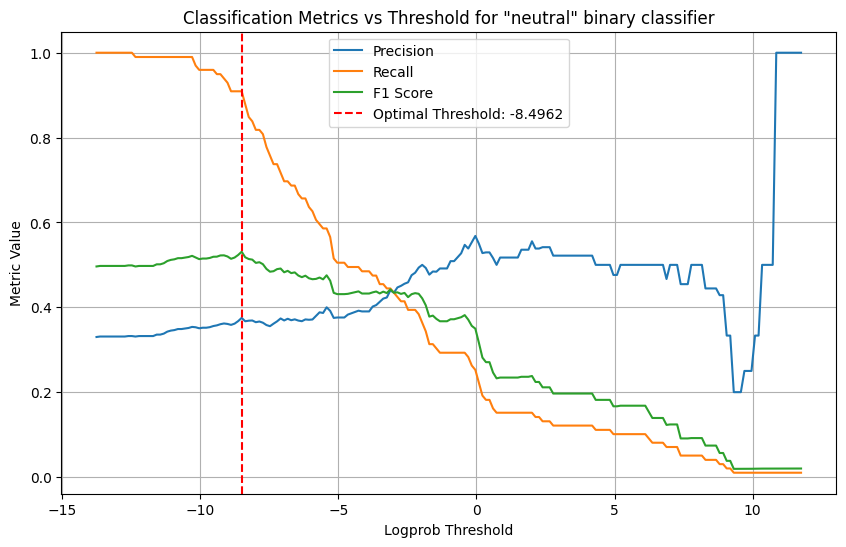

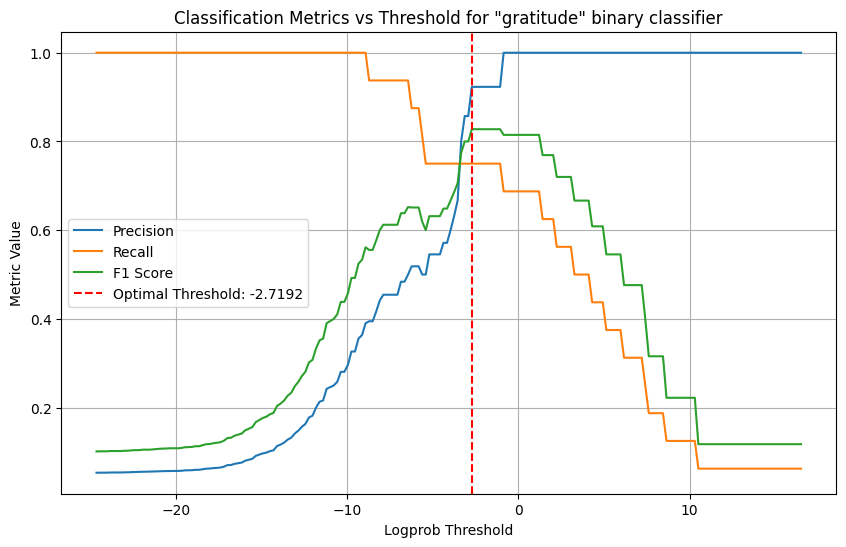

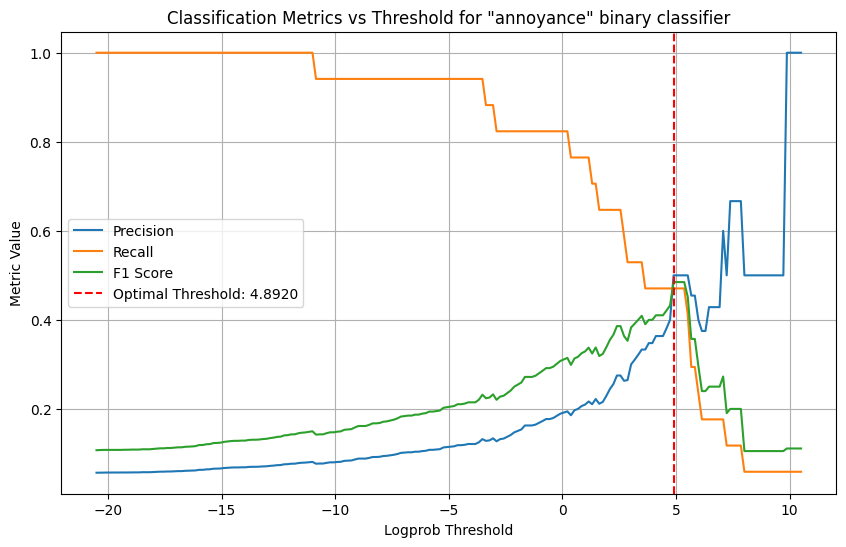

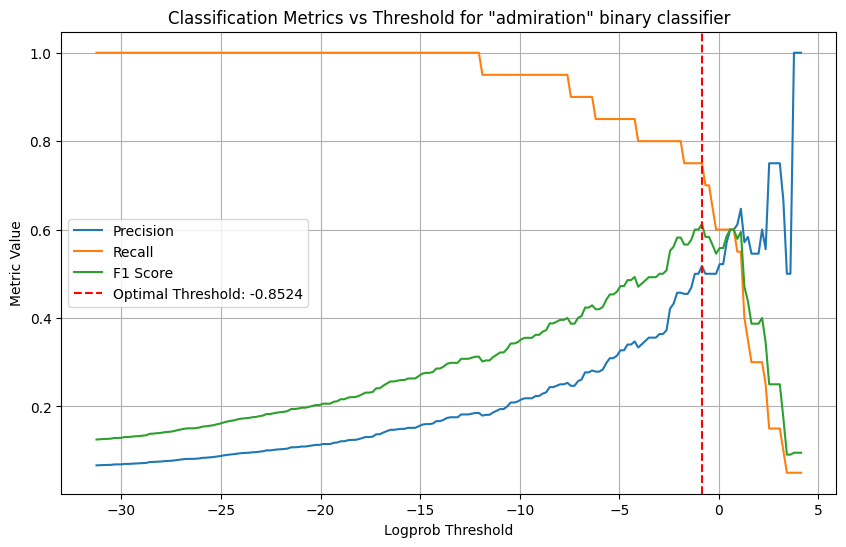

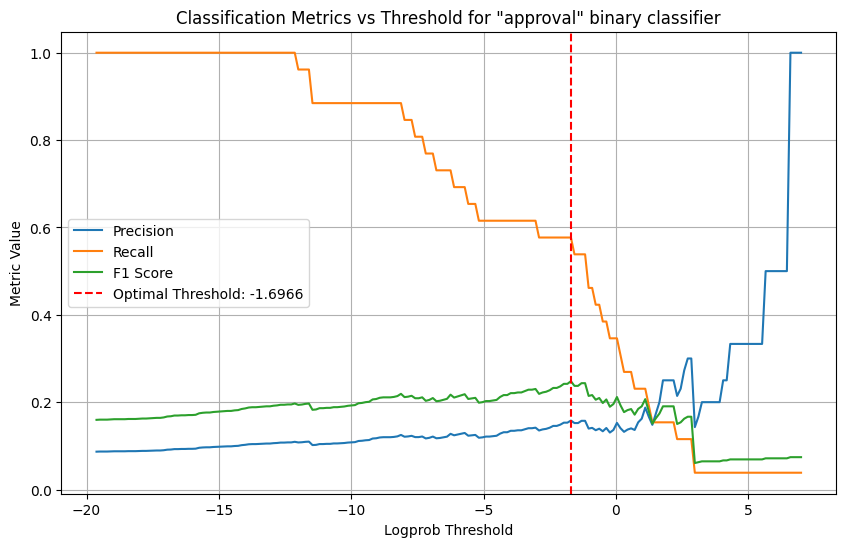

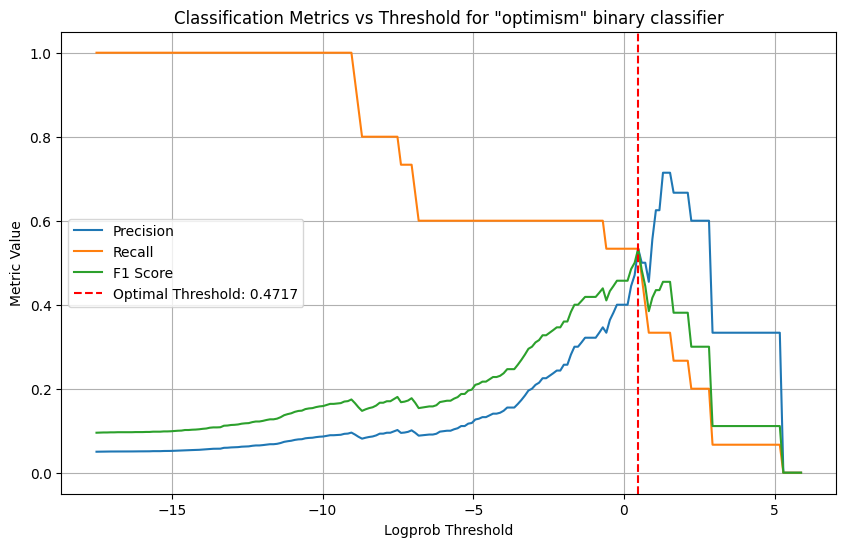

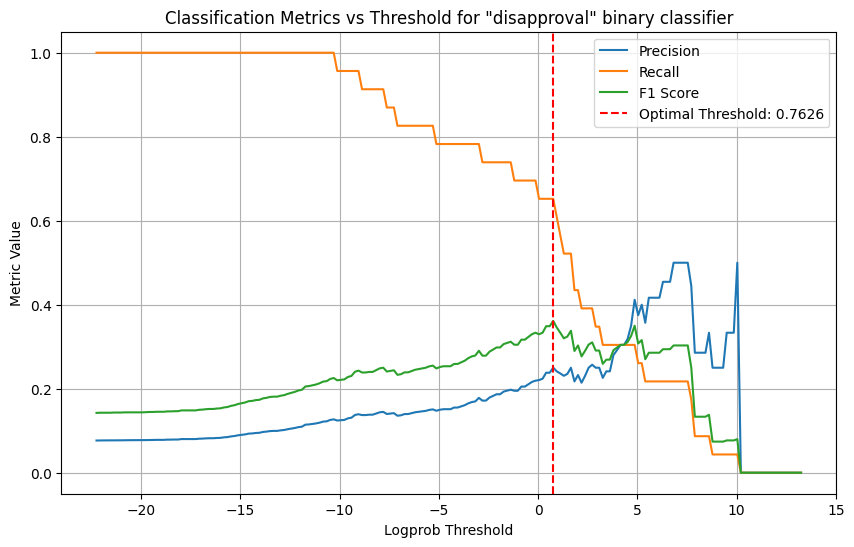

In [ ]:
for emotion in common_emotions:
  metrics_df = compute_metrics_df(scores_df.loc[:, emotion], labels_df.loc[:, emotion])
  best_row = metrics_df.loc[metrics_df.f1.idxmax()]
  optimal_threshold = best_row["threshold"]
  plot_precision_recall(metrics_df, emotion, optimal_threshold)

Let's generate a classification report, using a score cutoff of zero

In [ ]:
def print_classification_report(report):
    # 5. Display the precision and recall for the top 10 topics
    print(f"{'Emotion':<15} | {'Precision':<10} | {'Recall':<10} | {'F1-Score':<10}")
    print("-" * 55)

    for emotion in common_emotions:
        metrics = report[emotion]
        print(f"{emotion:<15} | {metrics['precision']:<10.2f} | {metrics['recall']:<10.2f} | {metrics['f1-score']:<10.2f}")

    # (Optional) Print the overall average scores from the report
    print("-" * 55)
    micro_avg = report['micro avg']
    print(f"{'Micro Avg':<15} | {micro_avg['precision']:<10.2f} | {micro_avg['recall']:<10.2f} | {micro_avg['f1-score']:<10.2f}")

In [ ]:
preds_df = scores_df.applymap(lambda x: 1 if x > 0 else 0)
report = classification_report(
    labels_df,
    preds_df,
    target_names=labels_df.columns,
    zero_division=0,
    output_dict=True
)

print_classification_report(report)

Emotion         | Precision  | Recall     | F1-Score  
-------------------------------------------------------
neutral         | 0.55       | 0.22       | 0.32      
gratitude       | 1.00       | 0.69       | 0.81      
annoyance       | 0.19       | 0.82       | 0.31      
admiration      | 0.52       | 0.60       | 0.56      
approval        | 0.15       | 0.35       | 0.21      
optimism        | 0.40       | 0.53       | 0.46      
disapproval     | 0.22       | 0.65       | 0.33      
-------------------------------------------------------
Micro Avg       | 0.31       | 0.42       | 0.36      


/tmp/ipython-input-4136951509.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  preds_df = scores_df.applymap(lambda x: 1 if x > 0 else 0)


As a comparision, let's test out a base line method: tf-idf + svm

In [ ]:
# Training...
X = train_df['text']
y_orig = [
    [label for label in curr_labels if label in common_emotions]
    for curr_labels in train_df['labels']
]

mlb = MultiLabelBinarizer()
y = mlb.fit_transform(y_orig)

model = make_pipeline(
    TfidfVectorizer(min_df=1),
    OneVsRestClassifier(LinearSVC(dual="auto", random_state=42))
)
model.fit(X, y)

# Evaluating...
X_val = sample_df['text']
validation_labels = [
    [label for label in curr_labels if label in common_emotions]
    for curr_labels in sample_df['labels']
]
y_val = mlb.transform(validation_labels)
y_pred = model.predict(X_val)

report = classification_report(
    y_val,
    y_pred,
    target_names=mlb.classes_,
    zero_division=0,
    output_dict=True # Get the report as a dictionary for easy filtering
)

print_classification_report(report)

Emotion         | Precision  | Recall     | F1-Score  
-------------------------------------------------------
neutral         | 0.49       | 0.48       | 0.49      
gratitude       | 1.00       | 0.69       | 0.81      
annoyance       | 0.67       | 0.12       | 0.20      
admiration      | 0.67       | 0.50       | 0.57      
approval        | 0.67       | 0.08       | 0.14      
optimism        | 0.50       | 0.07       | 0.12      
disapproval     | 0.80       | 0.17       | 0.29      
-------------------------------------------------------
Micro Avg       | 0.57       | 0.36       | 0.44      


We can see that performance is fairly similar between the two approaches on this data.

The tf-idf + svm approach has some obvious advantages. The main selling point of the LLM-based approach is that we don't need historical training examples to get decent results right away. Also, no need to understand anything about models and training them; we can just call the OpenAI API, albeit in a specific way.

## Classification with many output categories


What about when we have _thousands_ of output categories, and no historical training examples?

Specifying categories to the LLM does not scale to thousands of output categories - either as parallel calls or in a single prompt. But in this case we can use a pipeline of API calls with embeddings + semantic similarity.

Let's look at an examples of this approach on some StackOverlflow posts, predicting StackOverflow tags

In [ ]:
records = [
    {
        "title": "Is there a di-friendly File management library in Java?",
        "description": """I've used this library to work with files, but now I want to write simple unit tests.

Problem: Files class is static final, methods are static and so - are unmockable. For me it's frustrating, because I now need to actually test the file system and actually test the results, when all I need to do is really just mock methods. Not really unit testing, when you need to actually use the environment.

Example code of the code now:

public class MyClass
{
    public void myMethod(File myFile) throws IOException
    {
        Files.move(myFile.toPath(), myFile.toPath(), StandardCopyOption.REPLACE_EXISTING);
    }
}
I would like the code to be likes this:

public class MyClass
{
    private final Files files;

    public MyClass(Files files)
    {
        this.files = files;
    }

    public void myMethod(File myFile) throws IOException
    {
        this.files.move(myFile.toPath(), myFile.toPath(), StandardCopyOption.REPLACE_EXISTING);
    }
}
So what I need is a class that does the same as "Files" , but is injectable""",
        "labels": ["dependency-injection", "filesystems", "java"],
    },
    {
        "title": "Huge lots of errors when importing libraries",
        "description": """I suddenly got a lot of errors when importing libraries that i didn't have in the same script (exactly the same script) a few hours ago. This is what I import:

import pandas as pd
pd.core.common.is_list_like = pd.api.types.is_list_like
from pandas_datareader import data as web
import datetime
import fix_yahoo_finance as yf
import plotly
from plotly import figure_factory as ff
import os
And this is the huge amount of errors:

sh: module: line 1: syntax error: unexpected end of file
sh: error importing function definition for `module'
sh: switchml: line 1: syntax error: unexpected end of file
sh: error importing function definition for `switchml'
sh: scl: line 1: syntax error: unexpected end of file
sh: error importing function definition for `scl'
As I said, I didn't get any of those errors earlier, and can't find anything to fix it over the internet.

I'm using the last version of atom editor on fedora28.

Thanks for reading, guys! :)""",
        "labels": ["python", "import"],
    },
    {
        "title": "Can sympy simplify block matrix expressions?",
        "description": """Consider the following example: (I attempt to compute the matrix product involving a block matrix)

import sympy as sy

k, n = sy.symbols('k,n')
A = sy.MatrixSymbol("A", n, n)
B = sy.MatrixSymbol("B", n, k)
M = sy.BlockMatrix([[A * B, A]])
A.inverse() * M
which will output

A^-1*Matrix([[A*B, A]])
Is there a way to simplify/expand/cancel this to the more reader-friendly form of Matrix([[B, I]])?""",
        "labels": ["sympy", "python", "symbolic-math"],
    },
]

df = pd.DataFrame(records)

In [ ]:
df

,title,description,labels
0,Is there a di-friendly File management library in Java?,"I've used this library to work with files, but now I want to write simple unit tests.\n\nProblem: Files class is static final, methods are static and so - are unmockable. For me it's frustrating, because I now need to actually test the file system and actually test the results, when all I need to do is really just mock methods. Not really unit testing, when you need to actually use the environment.\n\nExample code of the code now:\n\npublic class MyClass\n{\n public void myMethod(File myFile) throws IOException\n {\n Files.move(myFile.toPath(), myFile.toPath(), StandardCopyOption.REPLACE_EXISTING);\n }\n}\nI would like the code to be likes this:\n\npublic class MyClass\n{\n private final Files files;\n\n public MyClass(Files files)\n {\n this.files = files;\n }\n\n public void myMethod(File myFile) throws IOException\n {\n this.files.move(myFile.toPath(), myFile.toPath(), StandardCopyOption.REPLACE_EXISTING);\n }\n}\nSo what I need is a class that does the same as ""Files"" , but is injectable","[dependency-injection, filesystems, java]"
1,Huge lots of errors when importing libraries,"I suddenly got a lot of errors when importing libraries that i didn't have in the same script (exactly the same script) a few hours ago. This is what I import:\n\nimport pandas as pd\npd.core.common.is_list_like = pd.api.types.is_list_like\nfrom pandas_datareader import data as web\nimport datetime\nimport fix_yahoo_finance as yf\nimport plotly\nfrom plotly import figure_factory as ff\nimport os\nAnd this is the huge amount of errors:\n\nsh: module: line 1: syntax error: unexpected end of file\nsh: error importing function definition for `module'\nsh: switchml: line 1: syntax error: unexpected end of file\nsh: error importing function definition for `switchml'\nsh: scl: line 1: syntax error: unexpected end of file\nsh: error importing function definition for `scl'\nAs I said, I didn't get any of those errors earlier, and can't find anything to fix it over the internet.\n\nI'm using the last version of atom editor on fedora28.\n\nThanks for reading, guys! :)","[python, import]"
2,Can sympy simplify block matrix expressions?,"Consider the following example: (I attempt to compute the matrix product involving a block matrix)\n\nimport sympy as sy\n\nk, n = sy.symbols('k,n')\nA = sy.MatrixSymbol(""A"", n, n)\nB = sy.MatrixSymbol(""B"", n, k)\nM = sy.BlockMatrix([[A * B, A]])\nA.inverse() * M\nwhich will output\n\nA^-1*Matrix([[A*B, A]])\nIs there a way to simplify/expand/cancel this to the more reader-friendly form of Matrix([[B, I]])?","[sympy, python, symbolic-math]"


In [ ]:
row = df.iloc[0]
title = row.title
description = row.description
title_and_description = f"{row.title}\n\n{row.description}"
labels = row.labels

As a first step, we extract tags irrespective of the actual valid tag choices

In [ ]:
def extract_tags_freeform(title_and_description):
  system_prompt = """You are an expert in StackOverflow.

You will receive the title and description of a StackOverflow post, and your task is to extract all appropriate tags.

Do this by scanning through the text and extracting all words/phrases that seem to be important in the StackOverflow post."""

  completion = client.chat.completions.create(
    model="gpt-4o",
    messages=[
      {
        "role": "developer",
        "content": system_prompt,
      },
      {
        "role": "user",
        "content": title_and_description,
      }
    ],
    response_format={
      "type": "json_schema",
      "json_schema": {
        "name": "list_response",
        "schema": {
          "type": "object",
          "properties": {
            "tags": {
              "type": "array",
              "items": {"type": "string"},
              "description": "Tags corresponding to the input StackOverflow post",
            },
          },
          "required": ["tags"],
          "additionalProperties": False,
        },
        "strict": True,
      },
    },
  )

  completion_dict = completion.model_dump()
  completion_json = completion_dict["choices"][0]["message"]["content"]
  tags = json.loads(completion_json)["tags"]

  return tags

tags_freeform = extract_tags_freeform(title_and_description)

In [ ]:
tags_freeform

['java',
 'file-management',
 'dependency-injection',
 'unit-testing',
 'mocking',
 'static-methods']

Next, let's limit it to the common valid StackOverflow tags

In [ ]:
!wget -O common_stackoverflow_tags.txt https://zenodo.org/records/5604548/files/_1_commonTags.csv?download=1

--2025-09-09 11:05:21--  https://zenodo.org/records/5604548/files/_1_commonTags.csv?download=1
Resolving zenodo.org (zenodo.org)... 188.185.45.92, 188.185.48.194, 188.185.43.25, ...
Connecting to zenodo.org (zenodo.org)|188.185.45.92|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 301877 (295K) [text/plain]
Saving to: ‘common_stackoverflow_tags.txt’

common_stackoverflo 100%[===================>] 294.80K  --.-KB/s    in 0.1s    

2025-09-09 11:05:21 (2.61 MB/s) - ‘common_stackoverflow_tags.txt’ saved [301877/301877]



In [ ]:
valid_labels = open("common_stackoverflow_tags.txt").read().splitlines()

In [ ]:
len(valid_labels)

23688

Next, we embed those valid tag strings. Note, this only has to be done once, in advance

In [ ]:
# Break into chunks of 1000:
chunks = [valid_labels[i:i+1000] for i in range(0, len(valid_labels), 1000)]

In [ ]:
valid_labels_embeddings = []
for chunk in tqdm(chunks):
  response = client.embeddings.create(
      input=chunk,
      model="text-embedding-3-large"
  )

  valid_labels_embeddings.extend([item.embedding for item in response.data])

  0%|          | 0/24 [00:00<?, ?it/s]

In [ ]:
valid_labels_embeddings = torch.tensor(valid_labels_embeddings)

In [ ]:
valid_labels_embeddings.shape

torch.Size([23688, 3072])

Now, we get the most similar _valid_ tag categories for each of our _freeform_ tags

In [ ]:
def get_most_similar(
    texts_1: list[str],
    texts_2: list[str],
    texts_2_embeddings: torch.Tensor,
    top_k: int = 20,
    device: str = 'cpu',
):
    texts_1_embeddings_data = client.embeddings.create(input=texts_1, model="text-embedding-3-large").data
    texts_1_embeddings = torch.tensor([item.embedding for item in texts_1_embeddings_data])

    """
    Finds the most similar texts using memory-efficient matrix multiplication.
    This is the preferred method when one set of embeddings is small (like your 6 texts).
    """
    texts_1_embeddings = texts_1_embeddings.to(device)
    texts_2_embeddings = texts_2_embeddings.to(device)

    norm_1 = F.normalize(texts_1_embeddings, p=2, dim=1)
    norm_2 = F.normalize(texts_2_embeddings, p=2, dim=1)
    similarities = torch.matmul(norm_1, norm_2.T)

    top_similarities, top_indices = torch.topk(similarities, k=top_k, dim=1)

    top_indices_cpu = top_indices.cpu()

    top_matches = []
    for indices in top_indices_cpu:
        top_matches.append([texts_2[i] for i in indices])

    return top_similarities.cpu(), top_matches

device = 'cuda' if torch.cuda.is_available() else 'cpu'

potential_match_similarities, potential_label_matches = get_most_similar(
    tags_freeform,
    valid_labels,
    valid_labels_embeddings,
    top_k=20,
    device=device
)

In [ ]:
labels

['dependency-injection', 'filesystems', 'java']

In [ ]:
tags_freeform

['java',
 'file-management',
 'dependency-injection',
 'unit-testing',
 'mocking',
 'static-methods']

In [ ]:
potential_label_matches[:3]

[['java',
  'java-me',
  'javax',
  'javah',
  'javap',
  'javascript',
  'javaw',
  'java-api',
  'java-ws',
  'jsp',
  'android',
  'javac',
  'jdk1.5',
  'java-5',
  'javapos',
  'java1.4',
  'java-home',
  'realm-java',
  'java-ee',
  'jdk1.4'],
 ['file-management',
  'file-manipulation',
  'file-manager',
  'file-organization',
  'file-handling',
  'document-management',
  'data-management',
  'file-structure',
  'file-storage',
  'file-processing',
  'folder-structure',
  'file-move',
  'database-management',
  'content-management',
  'file-browser',
  'file-access',
  'directory-structure',
  'process-management',
  'user-management',
  'project-management'],
 ['dependency-injection',
  'constructor-injection',
  'property-injection',
  'inversion-of-control',
  'spring-ioc',
  'simple-injector',
  'dependency-management',
  'external-dependencies',
  'autowired',
  'valueinjecter',
  'circular-dependency',
  'dependency-properties',
  'dependency-walker',
  'ninject',
  'maven-

Next, we select the single best match from each of the 20 most-similar candidates, for each of our freeform tags.

Side note: This is can be seen as a _multi-class_ classification task

In [ ]:
def select_best_matching_tag(
    free_form_tag: str,
    potential_matching_tags: list[str],
) -> tuple[str, float]:
    system_prompt = """You are an expert in StackOverflow.

You will receive a string that you should then match to a StackOverflow tag.

Your task is to select the StackOverflow tag that is most likely to be the same as that tag from the list of candidate tags. Focus on lexical similarity if the semantics is not obvious.
"""

    completion = client.chat.completions.create(
        model="gpt-4o",
        messages=[
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": free_form_tag},
        ],
        response_format={
            "type": "json_schema",
            "json_schema": {
                "name": "multiclass_classification",
                "schema": {
                    "type": "object",
                    "properties": {
                        "category": {
                            "type": "string",
                            "description": "StackOverflow tags that might match the input tag",
                            "enum": potential_matching_tags,
                        },
                    },
                    "required": ["category"],
                    "additionalProperties": False,
                },
                "strict": True,
            },
        },
    )

    classification_obj = json.loads(completion.choices[0].message.content)

    classification_call = (
        classification_obj["category"] if "category" in classification_obj else ""
    )

    return classification_call


best_matching_tags = [
    select_best_matching_tag(free_form_tag, potential_matching_tags)
    for free_form_tag, potential_matching_tags in zip(tags_freeform, potential_label_matches)
]

In [ ]:
best_matching_tags

['java',
 'file-management',
 'dependency-injection',
 'unit-testing',
 'mocking',
 'static-methods']

As a final step, let's score each of those (valid) tags to check if they do indeed match the StackOverflow post. For this, we can re-use our `classify_multilabel` function

In [ ]:
system_prompt = """You are an expert in StackOverflow.

You will receive a StackOverflow post. Your task is to determine which of a defined set of tags are suitable for that StackOverflow post."""

attribute_value_to_description = {
    tag: f"true if the tag \"{tag}\" is relevant to the input StackOverflow post, false otherwise."
    for tag in best_matching_tags
}
tag_scores = classify_text_multilabel(system_prompt, title_and_description, attribute_value_to_description)

In [ ]:
pd.Series(tag_scores).sort_values(ascending=False)

,0
java,20.500
file-management,15.375
dependency-injection,8.500
unit-testing,6.125
static-methods,4.750
mocking,4.000


In [ ]:
print(title_and_description)

Is there a di-friendly File management library in Java?

I've used this library to work with files, but now I want to write simple unit tests.

Problem: Files class is static final, methods are static and so - are unmockable. For me it's frustrating, because I now need to actually test the file system and actually test the results, when all I need to do is really just mock methods. Not really unit testing, when you need to actually use the environment.

Example code of the code now:

public class MyClass
{
    public void myMethod(File myFile) throws IOException
    {
        Files.move(myFile.toPath(), myFile.toPath(), StandardCopyOption.REPLACE_EXISTING);
    }
}
I would like the code to be likes this:

public class MyClass
{
    private final Files files;

    public MyClass(Files files)
    {
        this.files = files;
    }

    public void myMethod(File myFile) throws IOException
    {
        this.files.move(myFile.toPath(), myFile.toPath(), StandardCopyOption.REPLACE_EXISTING)

Let's try it out on the other two examples also

In [ ]:
#row = df.iloc[1]
row = df.iloc[2]
title = row.title
description = row.description
title_and_description = f"{row.title}\n\n{row.description}"
labels = row.labels

In [ ]:
tags_freeform = extract_tags_freeform(title_and_description)
potential_match_similarities, potential_label_matches = get_most_similar(tags_freeform, valid_labels, valid_labels_embeddings)
best_matching_tags = [
    select_best_matching_tag(free_form_tag, potential_matching_tags)
    for free_form_tag, potential_matching_tags in zip(tags_freeform, potential_label_matches)
]
attribute_value_to_description = {
    tag: f"true if the tag \"{tag}\" is relevant to the input StackOverflow post, false otherwise."
    for tag in best_matching_tags
}
tag_scores = classify_text_multilabel(system_prompt, title_and_description, attribute_value_to_description)

In [ ]:
pd.Series(tag_scores).sort_values(ascending=False)

,0
sympy,15.000
python,8.000
simplification,5.500
block,5.250
linear-algebra,1.375


In [ ]:
labels

['sympy', 'python', 'symbolic-math']

In [ ]:
print(title_and_description)

Can sympy simplify block matrix expressions?

Consider the following example: (I attempt to compute the matrix product involving a block matrix)

import sympy as sy

k, n = sy.symbols('k,n')
A = sy.MatrixSymbol("A", n, n)
B = sy.MatrixSymbol("B", n, k)
M = sy.BlockMatrix([[A * B, A]])
A.inverse() * M
which will output

A^-1*Matrix([[A*B, A]])
Is there a way to simplify/expand/cancel this to the more reader-friendly form of Matrix([[B, I]])?


## Summing up

### Caveats

- In theory it's possible to get logprobs with Gemini models also, but last time I tried (around March 2025) I could not get it to work reliably.
- There is some non-determinism in OpenAI's logprob scores, which should not be the case in theory (it could be due to differences in hardware on the OpenAI or perhaps non-determinism in the cuda kernals used).
- The logprob scores are also apparently _not_ influenced by temperature in the way that they should be, in theory. I speculate they return the results for a temperature value of 1, but then use the temperature-affected probabilities when performing sampling.
- The examples presented here use the [chat completions](https://platform.openai.com/docs/api-reference/chat) endpoint. Nowadays OpenAI recommend using the [responses](https://platform.openai.com/docs/api-reference/responses) endpoint instead. It apparently does now support logprobs, so it might be better to translate the API calls to that setup if you adopt these techniques. The concepts are the same.
- If you have high-quality historical labelled data, you may be better off with existing techniques (tf-idf + svm, BERT and co, etc.).
- You can easily do multi-modal classification (with images, sound, etc.), by modifying the user input in the OpenAI API call.
- This _is_ fairly new stuff. I have reasonable confidence in the methodologies outlined here and am getting decent results with them, but bear this in mind.

### Other points:

- We have not covered how to improve predictive performance of a prompt-based classifier. Briefly, my (current) recommendation for how to do this is to:
  - Generate predictions on a random sample of input examples -> Quantify performance using manually-generated derived on those examples -> Decide if good enough -> If not, identify common and/or bad modes of failure of the existing pipeline -> Modify prompt(s) / refine the pipeline / swap the model / adjust thresholds -> Repeat.
  - _However_: There may be better approaches. In particular, there are apparently some automated prompt improvement techniques, some of which are applicable even using LLM API calls. For example, DSPy. I have not experimented with them yet though.
- An extra benefit of scores: We can combine the output from multiple classifiers using some weighted average of the outputs, and thereby achieve improved predictive performance
- As a general pattern, a single binary classification step as a cross-check can be quite useful at the end of any given pipeline, to ensure high quality results. We've used the technique previously, for example to reduce hallucinations in news summaries.
- Knowledgable folks in the data science community often advance the argument that encoder-only models (such as BERT) are much better suited to classification tasks than decoder-only models. However, even with recent larger token windows for BERT (8k tokens vs only 512 previously), those approaches are not as convenient as simply prompting an LLM. I would argue both techniques are suitable in different scenarios.

### Further reading + listening

- OpenAI cookbook on logprobs: https://cookbook.openai.com/examples/using_logprobs
- Interview with Michelle Pokrass (from 2024): https://www.latent.space/p/openai-api-and-o1
- Intro to sampling in LLMs, including logprobs: https://huyenchip.com/2024/01/16/sampling.html?utm_source=chatgpt.com
- Precision and recall: https://en.wikipedia.org/wiki/Precision_and_recall
- Podcast interview covering LLM pipelines, error analysis: https://vanishinggradients.fireside.fm/57

I also highly recommend sparring with ChatGPT, Gemini, Claude etc. if you want to find out more about these technical topics; frontier LLMs are fairly reliable in this domain.

## Author
Thomas Whitington, PhD.

2025-09-05